# Composite spectrum (CS), ROOSTER, and Sph index (MSAP4-03)

In this notebook, we follow the flowchart defined for the PLATO MSAP4-03 submodule to show how the composite spectrum and the $S_\mathrm{ph}$ time series are computed. The final rotation period for the star is also computed through the random forest classifier analysis performed by the ROOSTER methodology.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import star_privateer as sp

## Preprocessing

We start by loading our usual K2 light curve (EPIC 211015853) and the intermediate data products we require from MSAP4-01 and 02. We also recompute the Lomb-Scargle periodogram as we need it for the composite spectrum.

In [3]:
t, s, dt = sp.load_k2_example ()
IDP_123_PROT_FOURIER = np.loadtxt ('data_products/IDP_123_PROT_FOURIER_K2.dat')
IDP_123_PROT_TIMESERIES = np.loadtxt ('data_products/IDP_123_PROT_TIMESERIES_K2.dat')
IDP_123_ACF_FILT_TIMESERIES = np.loadtxt ('data_products/IDP_123_ACF_FILT_TIMESERIES_K2.dat')

In [4]:
p_ps, ps_object = sp.compute_lomb_scargle (t, s)
ls = ps_object.power_standard_norm

## Computing the CS

The ACF is renormalised by its value at the main periodicity.

In [5]:
prot_acf = IDP_123_PROT_TIMESERIES[0,0]/IDP_123_PROT_TIMESERIES[0,5]
p_acf, acf = IDP_123_ACF_FILT_TIMESERIES[:,0], IDP_123_ACF_FILT_TIMESERIES[:,1]
index_prot_acf = np.where (prot_acf==p_acf)[0][0]

In [6]:
cs = sp.compute_cs (ls, acf, p_acf=p_acf, p_ps=p_ps,
                       index_prot_acf=index_prot_acf)

In [7]:
_, hcs = sp.find_prot_cs (p_acf, cs)
(prot_cs, E_prot_cs, 
 param_gauss_cs) = sp.compute_prot_err_gaussian_fit (p_acf, cs, verbose=False,
                                                  n_profile=5, threshold=0.1)

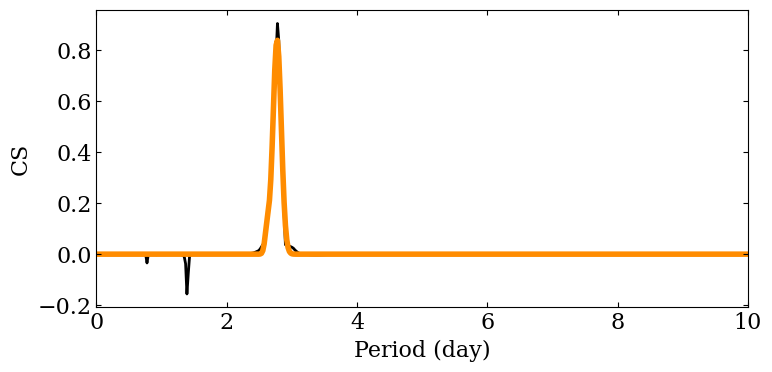

In [8]:
fig = sp.plot_cs (p_acf, cs, ax=None, figsize=(8, 4),
                    lw=2, filename='figures/cs_k2.png', dpi=300, 
                    param_gauss=param_gauss_cs,
                    xlim=(0, 10))

## ROOSTER analysis

Before using ROOSTER, we must gather the set of parameter it needs for the analysis. 
The candidate $S_\mathrm{ph}$ mean values for each possible periods are among this set. 

In [9]:
IDP_123_PROT_FOURIER.shape

(3, 5)

In [10]:
(prot_ps, e_prot_ps, E_prot_ps,
 h_ps, fa_prob_ps) = (IDP_123_PROT_FOURIER[0,0], 
                      IDP_123_PROT_FOURIER[0,1], 
                      IDP_123_PROT_FOURIER[0,2],
                      IDP_123_PROT_FOURIER[0,3],
                      IDP_123_PROT_FOURIER[0,4])
(prot_acf, e_prot_acf, E_prot_acf,
 hacf, gacf) = (IDP_123_PROT_TIMESERIES[0,0], 
                IDP_123_PROT_TIMESERIES[0,1], 
                IDP_123_PROT_TIMESERIES[0,2],
                IDP_123_PROT_TIMESERIES[0,3], 
                IDP_123_PROT_TIMESERIES[0,4])

In [11]:
sph_ps = sp.compute_sph (t, s, prot_ps)
sph_acf = sp.compute_sph (t, s, prot_acf)
sph_cs = sp.compute_sph (t, s, prot_cs)

In [12]:
features = np.array ([prot_ps, prot_acf, prot_cs,
                     e_prot_ps, E_prot_ps,
                     e_prot_acf, E_prot_acf,
                     E_prot_cs, E_prot_cs,
                     sph_ps, sph_acf, sph_cs,
                     h_ps, fa_prob_ps, hacf, gacf, hcs])
feature_names = np.array(['prot_ps', 'prot_acf', 'prot_cs',
                         'e_prot_ps', 'E_prot_ps',
                         'e_prot_acf', 'E_prot_acf',
                         'e_prot_cs', 'E_prot_cs',
                         'sph_ps', 'sph_acf', 'sph_cs',
                         'h_ps', 'fa_prob_ps',
                         'hacf', 'gacf', 'hcs'])
df = pd.DataFrame (columns=feature_names, index=[211015853],
                   data=features.reshape (-1, features.size))
df

,prot_ps,prot_acf,prot_cs,e_prot_ps,E_prot_ps,e_prot_acf,E_prot_acf,e_prot_cs,E_prot_cs,sph_ps,sph_acf,sph_cs,h_ps,fa_prob_ps,hacf,gacf,hcs
211015853,2.787376,2.676551,2.773161,0.027603,0.028161,-1.0,-1.0,0.090444,0.090444,4591.42627,4672.765625,4606.483398,0.422299,1.000000e-16,0.825423,1.250446,0.904589


We create the data structure that ROOSTER will need.

In [13]:
(target_id, p_candidates, 
 e_p_candidates, E_p_candidates, 
 features, feature_names) = sp.create_rooster_feature_inputs (df, return_err=True)
p_candidates

array([[2.78737645, 2.6765511 , 2.77316149]])

Now, we load and use the ROOSTER object.

In [14]:
chicken = sp.load_rooster_instance (filename='rooster_instances/rooster_tutorial')

In [15]:
rotation_score, prot, e_p, E_p = chicken.analyseSet (features, p_candidates, e_p_err=e_p_candidates,
                                                     E_p_err=E_p_candidates, feature_names=feature_names)

In [16]:
rotation_score, prot, e_p, E_p

(array([0.99]), array([2.78737645]), array([0.02760309]), array([0.02816084]))

## Computing $S_\mathrm{ph}$ time series

Now that we have the final value of the rotation period, we can correctly compute the $S_\mathrm{ph}$ time series.

In [17]:
_, t_sph, sph_series = sp.compute_sph (t, s, prot, 
                                          return_timeseries=True)

We show below the $S_\mathrm{ph}$ evolution along time compared with the time series flux evolution.

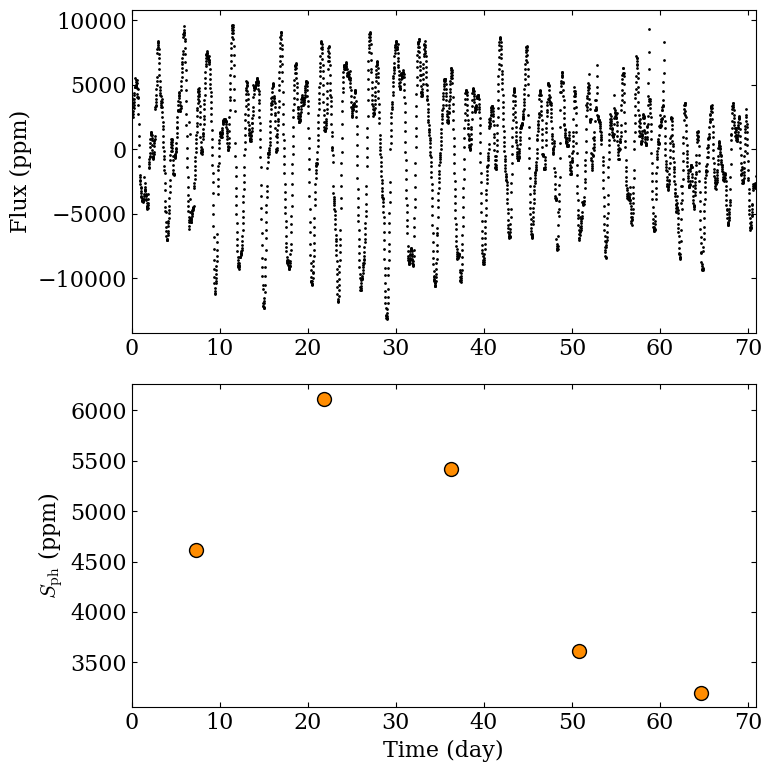

In [18]:
fig, (ax1, ax2) = plt.subplots (2, 1, figsize=(8,8))

ax1.scatter (t - t[0], s, marker='o', facecolor='black', s=1)
ax2.scatter (t_sph - t[0], sph_series, marker='o', s=100,
            facecolor='darkorange', edgecolor='black')

ax1.set_ylabel (r'Flux (ppm)')
ax2.set_xlabel ('Time (day)')
ax2.set_ylabel (r'$S_\mathrm{ph}$ (ppm)')

ax1.set_xlim (0, t[-1]-t[0])
ax2.set_xlim (0, t[-1]-t[0])

fig.tight_layout ()

plt.savefig ('figures/sph_k2.png', dpi=300)

## Computing the Rossby number

It is now possible to compute an estimate of the fluid Rossby number from the rotation period and the effective temperature. Here, we use the $T_\mathrm{eff} = 5888$ value from the GAIA DR3 catalog.

In [19]:
teff = 5888 
ro, flag = sp.compute_rossby (prot[0], teff)
ro, flag

(0.11725583789569136, 5)

## Differential rotation candidates validation

We now use IDP_123_PROT_FOURIER to validate the possible differential rotation candidates. 

In [20]:
dr, e_dr, E_dr, shear = sp.compute_delta_prot (prot[0], IDP_123_PROT_FOURIER[1:,0], 
                                           IDP_123_PROT_FOURIER[1:,1],
                                           IDP_123_PROT_FOURIER[1:,2],
                                           delta_min=1/3, delta_max=5/3,
                                           tol_harmonic=0.05)
dr, e_dr, E_dr, shear

(-1, -1, -1, -1)

## Building the data products

Finally, we build the data products from the previous computations.

In [21]:
IDP_123_S_PHOTO_INDEX = np.c_[t_sph, sph_series]
DP4_123_PROT_NOSPOT = np.array ([prot[0], e_p[0], E_p[0], 
                                 ro, flag, 
                                 np.mean (sph_series), np.std (sph_series)])
DP4_123_DELTA_PROT_NOSPOT = np.c_[dr, e_dr, E_dr, shear]

In [22]:
np.savetxt ('data_products/IDP_123_S_PHOTO_INDEX_K2.dat', IDP_123_S_PHOTO_INDEX)
np.savetxt ('data_products/DP4_123_PROT_NOSPOT_K2.dat', DP4_123_PROT_NOSPOT)
np.savetxt ('data_products/DP4_123_DELTA_PROT_K2.dat', DP4_123_DELTA_PROT_NOSPOT)